# Deep Unet
### Import packet 

In [1]:
pip install --upgrade install tensorflow==2.0.0.

     |████████████████████████████████| 86.3 MB 43 kB/s 
     |████████████████████████████████| 3.8 MB 49.4 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 449 kB 50.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=cbab5381241155711006f5b21ade2562f537be1ba4b4aba3d4679bdd24eef0ab
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [2]:
pip install --upgrade install keras==2.3.0.

     |████████████████████████████████| 377 kB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [3]:
!git clone https://github.com/yesidfonseca/DeepPriorCS.git DeepPriorCS

Cloning into 'DeepPriorCS'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [4]:
cd DeepPriorCS

/content/DeepPriorCS


In [5]:
from MAIN import *  # donde esta el modelo y las funciones necesarias como psnr y demas 
from scipy.sparse import csr_matrix, find
print(tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


2.0.0


In [8]:
def Hxfunction(x,largo,ancho,profun,H,Scale2D=0):
    Aux = tf.reshape(x,(largo,ancho,profun))    
    Aux = tf.math.multiply(Aux,H)
    #Aux = tf.math.reduce_sum(Aux,axis=2)    
    Aux = tf.reshape(Aux,(1,largo,ancho,profun))
    return Aux

In [9]:
def UNetL(pretrained_weights = None,input_size = (256,256,1), L=10, H=0, fact = 0.5):
    L_2 = 2*L;
    L_3 = 3*L;
    L_4 = 4*L;
    
    startLayer = Input(input_size)  
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(startLayer)
    
    conv1 = Dropout(0.2)(inicial)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(L_4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)    

    up5 = Conv2D(L_3, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(L_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(L, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal',)(conv7)

    conv8 = Conv2D(L, 1)(conv7)
    
    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (conv8)

    model = Model(input=startLayer, output=final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [10]:
def residualNet(pretrained_weights = None,input_size = (256,256,1), L=10, H=0,Scale2D = 0, fact = 0.5):
    
    inputs = Input(input_size)
    inicial = XoLayer(largo = input_size[0], ancho = input_size[1], profun = L, fact = fact)(inputs)
    
    drop1 = Dropout(0)(inicial)
    conv1 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(drop1)
    conv1 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(conv1)
    
    
    conv8 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(conv1)
    conv8 = Conv2D(L,3,activation='relu',use_bias=True,padding='same',kernel_initializer='he_normal')(conv8)
    
    
    conv8 = Add()([conv8,conv1])
    
    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H,Scale2D=Scale2D)) (conv8)
    
    model = Model(input = inputs, output = final)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
def Auto_encoder(pretrained_weights=None, input_size=(256, 256, 1), L=10, H=0, fact=0.5):
    L_2 = 2 * L;
    L_3 = 3 * L;
    L_4 = 4 * L;
    
    inputs = Input(input_size)    
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    
    # the encoder part
    conv1 = Dropout(0.2)(inicial)    
    conv1 = Conv2D(L, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(L_2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(L_3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(4, 4))(conv3)
    
    convup2=Conv2DTranspose(filters=L_3, kernel_size=(3, 3), strides=4, activation='relu', padding='same')(pool3)
    convup3=Conv2DTranspose(filters=L_2, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(pool2)
    conv8=Conv2DTranspose(filters=L, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(convup3)


    final = Lambda(lambda x: Hxfunction(x, largo=input_size[0],ancho=input_size[1],profun=L, H=H))(conv8)

    model = Model(input=inputs, output=final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [6]:
# Load Data
Mat= scipy.io.loadmat('LegoCars.mat')
testSI=np.double(Mat['hyperimg'])
testSI = testSI[::2,::2,(8, 4, 1)];
testSI=testSI/np.max(testSI)
RGB = testSI[:,:,:]#(8, 4, 1)]
[m,n,l]=testSI.shape

In [ ]:
#Define H
H_s = ((np.random.rand(m,n,l)<0.5)).astype(float)# - ((np.random.rand(m,n,l)<0.5).astype(float))
Scale2D = 1/(np.sum(H_s,axis=2)+1);
H_s = np.multiply(H_s, np.dstack([Scale2D]*l))
H_s = tf.constant(H_s,dtype='float32')


# Measurements
y = Hxfunction(tf.constant(testSI,dtype='float32'),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

In [ ]:
#Define H : second attempt
import cv2
edges_detected = cv2.Canny((testSI[:,:,:]*255).astype('uint8') ,threshold1=100, threshold2=100) 
edges_detected = edges_detected>0;
edges_detected = np.dstack([edges_detected]*l)
RandPanel = np.ones((m,n,l))>1;
RandPanel[0::10,0::10,:] = True;
RandPanel[4::10,4::10,:] = True; #(np.random.rand(m,n,l)<.05)
RandPanel[2::10,2::10,:] = True;
RandPanel[6::10,6::10,:] = True;
RandPanel[6::10,6::10,:] = True;
H_s = ((np.random.rand(m,n,l)<.05)+edges_detected).astype(float);# - ((np.random.rand(m,n,l)<0.5).astype(float))
print(H_s.sum()/(m*n*l))
H_s = tf.constant(H_s,dtype='float32')


# Measurements
y = Hxfunction(tf.constant(testSI,dtype='float32'),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

ValueError: ignored

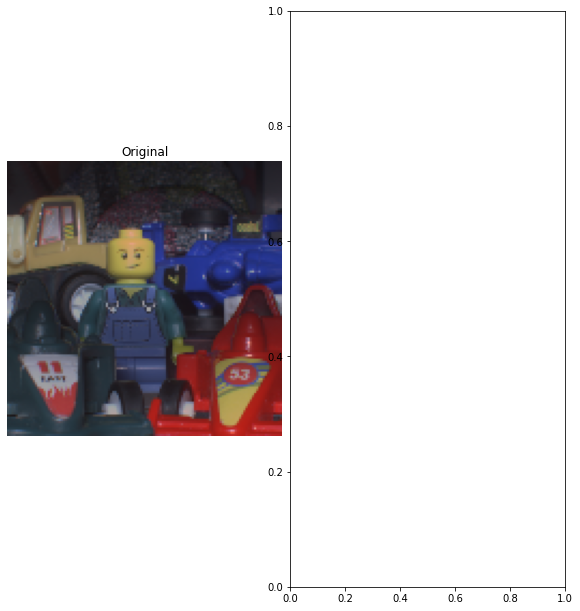

In [123]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.03)


axs[0].imshow(RGB)
axs[0].axis('off')
axs[0].set_title('Original')


axs[1].imshow(y.reshape((m,n+l-1),order="F")/np.max(y))
axs[1].axis('off')
axs[1].set_title('Measurements')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


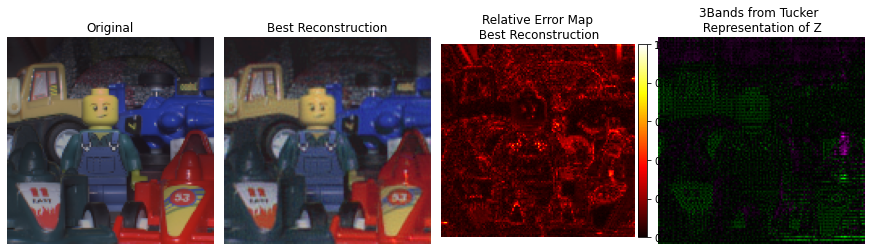

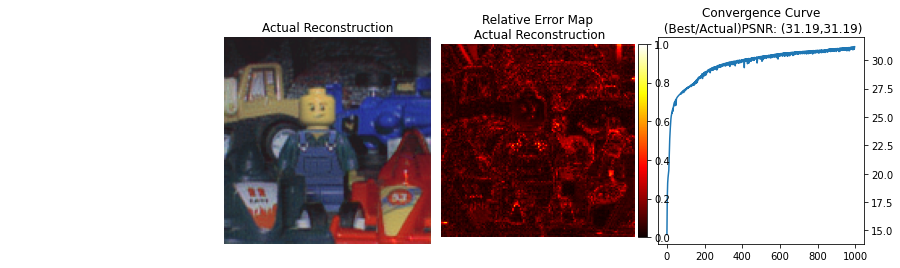

In [21]:
#Fixing random seed 
import random
tf.random.set_seed(1)
random.seed(1)



#Reconstruction Parameters setup
rho = .4
learning_rate = 1e-2
iters = 10000

#Visualization Parameters setup
Freq = 10



#Optimization
model = residualNet(input_size = (m,n,l), L=l,H=H_s, fact= rho)#Scale2D = Scale2D
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9,epsilon=1e-07, amsgrad=True);
#optimizad = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True);
        
model.compile(optimizer=optimizad, loss='mean_squared_error')
model.fit(np.zeros(shape=(1,m,n,l)), y, epochs = iters,batch_size=1,callbacks=[myCallback(testSI,Freq,[0,1,2])],verbose=0)
 
#Best Result
BestResult= model.Best
PSNR_Best = fun_PSNR(testSI,BestResult)

#Final Result
func = K.function([model.layers[0].input],[model.layers[len(model.layers)-2].output])
FinalResult = func(np.zeros(shape=(m,n,l)))
FinalResult = np.asarray(FinalResult).reshape((m,n,l),order="F")
PSNR_Final = fun_PSNR(testSI,FinalResult)

#Convergence Curve
PSNRs = model.PSNRs
PSNRs = PSNRs[1:len(PSNRs)-1]

#Low-Rank Tucker Representation of tensor Z
func = K.function([model.layers[0].input],[model.layers[1].output])
ZTuckerRepr = func(np.zeros(shape=(m,n,l)))
ZTuckerRepr = np.asarray(ZTuckerRepr).reshape((m,n,l),order="F")

#Visual Results
VisualGraphs(FinalResult,BestResult,ZTuckerRepr,PSNRs,testSI,[0,1,2])
    


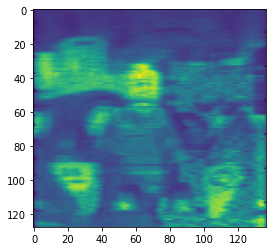

In [55]:
from scipy.sparse import diags, coo_matrix, block_diag
#H_t = np.hstack((((np.random.rand(m,n)<0.1)).astype('float32'),np.zeros(shape = (m,l-1),dtype='float32')))
#H_t = np.tile(np.tile(np.array([[1,1,1,1,0,0,1,1,1,1],[0,0,0,1,0,0,1,0,0,0],[0,1,1,1,0,0,1,1,1,0],[0,1,0,0,0,0,0,0,1,0],[0,1,1,1,1,1,1,1,1,0],[0,0,0,0,1,0,0,1,0,0],[1,1,1,0,1,0,0,1,0,0],[1,0,1,0,1,1,1,1,1,1],[1,0,1,1,1,0,0,1,0,0],[1,0,0,0,0,0,0,1,0,0]]),100).transpose(),100)
H_t = np.tile(np.tile(np.array((np.random.rand(20,20)<0.9).astype('float32')),100).transpose(),100)
H_t = np.hstack(((H_t[0:m,0:n]).astype('float32'),np.zeros(shape = (m,l-1),dtype='float32')))
#H_t = y[:,:,:,:].reshape((m,n),order="F")/np.max(y)
#print(H_t.flatten('F'))
#print(H_t)
D_t = H_t.flatten('F')
H_t = diags(D_t,shape=(D_t.shape[0], D_t.shape[0]))
(I,J,V) = find(H_t)
H = csr_matrix((V, (I, J)), shape=(m*(n+l-1), m*n)) 
for i in range(l-1):
  I = I+m;
  H_t = csr_matrix((V, (I, J)), shape=(m*(n+l-1), m*n))
  H = block_diag((H,H_t))

(I,J,V) = find(H)
H_s = tf.SparseTensor(indices = np.transpose(np.asarray([I,J]),(1,0)), values = V, dense_shape=[H.shape[0], H.shape[1]])

def Hxfunction(x,largo,ancho,profun,H,Scale2D):
    Aux = tf.reshape(x,(largo,ancho,profun))
    Aux = tf.transpose(Aux,perm=[2,1,0])
    Aux = tf.reshape(Aux,(largo*ancho*profun,1))

    Aux = tf.sparse.sparse_dense_matmul(H,Aux) 
    
    Aux = tf.reshape(Aux,(profun,ancho+profun-1,largo))
    Aux = tf.transpose(Aux,perm=[2,1,0])
    Aux = tf.reduce_sum(Aux,axis=2)
    Aux = tf.reshape(Aux,(1,largo,ancho+profun-1))
    Aux = tf.math.multiply(Aux,Scale2D)
    return Aux


Scale2D = Hxfunction(tf.constant(1,dtype='float32',shape = (m,n,l)),largo=m,ancho=n,profun=l,H=H_s,Scale2D = tf.constant(1,dtype='float32',shape = (1,m,n+l-1)))
Scale2D = 1/(Scale2D+1)

x_ = tf.constant(testSI,dtype='float32')
y = Hxfunction(x_,largo=m,ancho=n,profun=l,H=H_s,Scale2D = Scale2D)
y = np.double(y.numpy())
plt.imshow(y.reshape((m,n+l-1),order="F")/np.max(y))

In [112]:
import sys
sys.getsizeof(testSI.astype('float32'))
model.count_params()/(128*128*10)
l

3

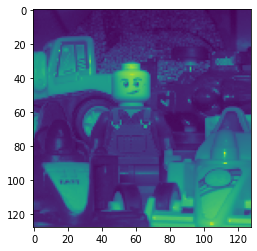

In [11]:
H_s = tf.constant(1,dtype='float32',shape=(m,n,l))
x_ = tf.constant(testSI,dtype='float32')
y = Hxfunction(x_,largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())
plt.imshow(y[:,:,:,0].reshape((m,n),order="F")/np.max(y))